In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), "swin_t", "mmdet", "models", "backbones"))
sys.path.insert(0, os.path.join(os.getcwd(), "reference_detection"))

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
from torchvision.transforms import ToPILImage

import random
import torch.backends.cudnn as cudnn

from torchvision.models.detection import MaskRCNN, RetinaNet
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torchvision.ops import FeaturePyramidNetwork



from torchvision.ops import misc as misc_nn_ops
from torchvision.ops.feature_pyramid_network import LastLevelP6P7, LastLevelMaxPool
from torchvision.models.detection.mask_rcnn import _resnet_fpn_extractor, _validate_trainable_layers



import matplotlib.pyplot as plt
from PIL import Image

import utils
import transforms as T
from engine import train_one_epoch
from engine import evaluate
import swin_transformer

apex is not installed


In [2]:
sys.path.insert(0, os.path.join(os.getcwd(), "swin_t", "mmdet", "models", "backbones"))
sys.path.insert(0, os.path.join(os.getcwd(), "reference_detection"))

import swin_transformer

In [3]:
os.getcwd()

'c:\\github\\vig_project'

In [4]:
random_seed = 42

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(random_seed)

In [5]:
ROOT = os.path.join(os.getcwd(), 'dataset')
PED_DATA_DIR = os.path.join(ROOT, 'PennFudanPed')
VOC_DATA_DIR = os.path.join(ROOT, 'VOC2012')

In [6]:
class PennFudanDataset(Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [7]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    # transforms.append(T.ResizeImage(1312, 800)) # image size 고정
    #transforms.append(T.FixedSizeCrop(224, 224)) # image size 고정
    transforms.append(T.FixedSizeCrop(800, 800))
    
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [8]:
dataset_ped = PennFudanDataset(PED_DATA_DIR, get_transform(train=True))
dataset_test_ped = PennFudanDataset(PED_DATA_DIR, get_transform(train=False))

indices = torch.randperm(len(dataset_ped)).tolist()
dataset_ped = torch.utils.data.Subset(dataset_ped, indices[:-50])
dataset_test_ped = torch.utils.data.Subset(dataset_test_ped, indices[-50:])

# define training and validation data loaders
data_loader_ped = torch.utils.data.DataLoader(
    dataset_ped, batch_size=1, shuffle=True,
    collate_fn=utils.collate_fn)

data_loader_test_ped = torch.utils.data.DataLoader(
    dataset_test_ped, batch_size=1, shuffle=False,
    collate_fn=utils.collate_fn)
    
num_classes_ped = 2

In [9]:
dataset_ped.__getitem__

<bound method Subset.__getitem__ of <torch.utils.data.dataset.Subset object at 0x0000023B0D20DF00>>

# Backbone

In [10]:
trainable_backbone_layers = _validate_trainable_layers(True, None, 5, 3)
resnet_50 = torchvision.models.resnet50(weights="DEFAULT", norm_layer=misc_nn_ops.FrozenBatchNorm2d)
mask_resnet_fpn = _resnet_fpn_extractor(resnet_50, trainable_backbone_layers)
retina_resnet_fpn = _resnet_fpn_extractor(resnet_50, trainable_backbone_layers, returned_layers=[2, 3, 4], extra_blocks=LastLevelP6P7(256, 256))

mask_resnet_fpn.out_channels = retina_resnet_fpn.out_channels = 256

In [11]:
swin_t = swin_transformer.SwinTransformer()
swin_t_fpn = FeaturePyramidNetwork(
            in_channels_list=[96, 192, 384, 768],
            out_channels=256,
            extra_blocks=LastLevelMaxPool()# LastLevelMaxPool(),
        )

c:\Users\euna\miniconda3\envs\project\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
swin_t_with_fpn = nn.Sequential(swin_t, swin_t_fpn)
swin_t_with_fpn.out_channels = 256


In [13]:
import pyramid_vig

# p_vig = pyramid_vig.pvig_ti_224_gelu()
p_vig = pyramid_vig.pvig_s_224_gelu()
p_vig_fpn = FeaturePyramidNetwork(
    in_channels_list=[80, 160, 400, 640],
    out_channels=256,
    extra_blocks=LastLevelMaxPool()
)

p_vig_with_fpn = nn.Sequential(p_vig, p_vig_fpn)
p_vig_with_fpn.out_channels = 256

<pyramid_vig.pvig_s_224_gelu.<locals>.OptInit object at 0x0000023B0D555B40>
using relative_pos
relative_pos shape (40000, 40000)
using relative_pos
relative_pos shape (40000, 40000)
using relative_pos
relative_pos shape (10000, 10000)
using relative_pos
relative_pos shape (10000, 10000)
using relative_pos
relative_pos shape (2500, 2500)
using relative_pos
relative_pos shape (2500, 2500)
using relative_pos
relative_pos shape (2500, 2500)
using relative_pos
relative_pos shape (2500, 2500)
using relative_pos
relative_pos shape (2500, 2500)
using relative_pos
relative_pos shape (2500, 2500)
using relative_pos
relative_pos shape (2500, 2500)
using relative_pos
relative_pos shape (2500, 2500)
using relative_pos
relative_pos shape (2500, 2500)
using relative_pos
relative_pos shape (2500, 2500)
using relative_pos
relative_pos shape (2500, 2500)
using relative_pos
relative_pos shape (2500, 2500)
using relative_pos
relative_pos shape (2500, 2500)
using relative_pos
relative_pos shape (2500, 2500

In [14]:
# mask_backbone = swin_t_with_fpn
# retina_backbone = swin_t_with_fpn
# use_fpn = True
# num_classes = num_classes_ped



mask_backbone = p_vig_with_fpn
retina_backbone = p_vig_with_fpn
use_fpn = True
num_classes = num_classes_ped



# MaskRCNN

In [15]:
pre_mask = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

In [16]:
if use_fpn:
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,), (256,), (512,)),
        aspect_ratios=((0.5, 1.0, 2.0),
                       (0.5, 1.0, 2.0),
                       (0.5, 1.0, 2.0),
                       (0.5, 1.0, 2.0),
                       (0.5, 1.0, 2.0)))
else:
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128),),
        aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'],
                                output_size=7,
                                sampling_ratio=2)

mask_roi_pooler = MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'],
                                                        output_size=14,
                                                        sampling_ratio=2)

custom_mask = MaskRCNN(
    mask_backbone,
    num_classes=num_classes,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
    mask_roi_pool=mask_roi_pooler,)

# RetinaNet

In [17]:
# pre_retina = torchvision.models.detection.retinanet_resnet50_fpn(weights="DEFAULT")

In [18]:
if use_fpn:
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,), (256,), (512,)),
        aspect_ratios=((0.5, 1.0, 2.0),
                       (0.5, 1.0, 2.0),
                       (0.5, 1.0, 2.0),
                       (0.5, 1.0, 2.0),
                       (0.5, 1.0, 2.0)))
else:
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128),),
        aspect_ratios=((0.5, 1.0, 2.0),))


custom_retina = RetinaNet(
    retina_backbone,
    num_classes=num_classes,
    anchor_generator=anchor_generator
)

# Select model and data_loader

In [19]:

data_loader = data_loader_ped
data_loader_test = data_loader_test_ped

#pre_retina # custom_retina # custom_mask # pre_mask
model = custom_retina # swin_t_fpn
#model = custom_mask


In [20]:
# i = iter(data_loader)
# images, _ = next(i)

In [21]:
# images[0].shape

In [22]:
# import pyramid_vig

# # model = pyramid_vig.pvig_ti_224_gelu()
# model = pyramid_vig.pvig_s_224_gelu()
# image = images[0].unsqueeze(0)

In [23]:
# outs = model(image)

In [24]:
# for k, v in outs.items():
#    print(f"{k}: {v.shape}")

# Training

In [25]:
# For Training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1.2e-4,
                            weight_decay=0.2)
# optimizer = torch.optim.SGD(params, lr=0.005,
#                             momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

In [26]:
model.backbone

Sequential(
  (0): DeepGCNI(
    (stem): Stem(
      (convs): Sequential(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate=none)
        (3): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): GELU(approximate=none)
        (6): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (deep_gcn): DeepGCN(
      (stem): Stem(
        (convs): Sequential(
          (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GELU(approximate=none)
          (3): Conv2d(40, 80, kernel_s

In [27]:
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")
print()

Epoch: [0]  [  0/120]  eta: 0:06:52  lr: 0.000120  loss: 1.7919 (1.7919)  classification: 1.1318 (1.1318)  bbox_regression: 0.6601 (0.6601)  time: 3.4353  data: 0.0519  max mem: 5416
Epoch: [0]  [ 10/120]  eta: 0:03:09  lr: 0.000120  loss: 1.9014 (1.8922)  classification: 1.1318 (1.1335)  bbox_regression: 0.7748 (0.7587)  time: 1.7253  data: 0.0174  max mem: 6101
Epoch: [0]  [ 20/120]  eta: 0:02:34  lr: 0.000120  loss: 1.8088 (1.8105)  classification: 1.1249 (1.1103)  bbox_regression: 0.6934 (0.7002)  time: 1.4542  data: 0.0161  max mem: 6102
Epoch: [0]  [ 30/120]  eta: 0:02:12  lr: 0.000120  loss: 1.6158 (1.6789)  classification: 1.0561 (1.0429)  bbox_regression: 0.5634 (0.6360)  time: 1.3416  data: 0.0176  max mem: 6103
Epoch: [0]  [ 40/120]  eta: 0:01:56  lr: 0.000120  loss: 1.3562 (1.6027)  classification: 0.8230 (0.9847)  bbox_regression: 0.5375 (0.6180)  time: 1.3546  data: 0.0161  max mem: 6103
Epoch: [0]  [ 50/120]  eta: 0:01:41  lr: 0.000120  loss: 1.2963 (1.5223)  classificat

In [28]:
model.eval()

RetinaNet(
  (backbone): Sequential(
    (0): DeepGCNI(
      (stem): Stem(
        (convs): Sequential(
          (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GELU(approximate=none)
          (3): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (4): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): GELU(approximate=none)
          (6): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (7): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (deep_gcn): DeepGCN(
        (stem): Stem(
          (convs): Sequential(
            (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2)

In [29]:
# import torchsummary
# # torchsummary.summary(model, input_size=torch.Size([3, 700, 700]))
# torchsummary.summary(model, (3,700,700))
# import pytorch_model_summary
# print(pytorch_model_summary.summary(model, images[0], show_input=True))

In [30]:
i = iter(data_loader_test)
images, targets = next(i)
images = list(img.to(device) for img in images)
images[0].shape

torch.Size([3, 800, 800])

In [31]:
targets[0].keys()

dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])

In [32]:

images_tensor = torch.stack(images, dim=0)        #리스트안에 텐서를 쌓아서 텐서로 만듬

In [33]:
type(images)

list

In [34]:
type(images_tensor)

torch.Tensor

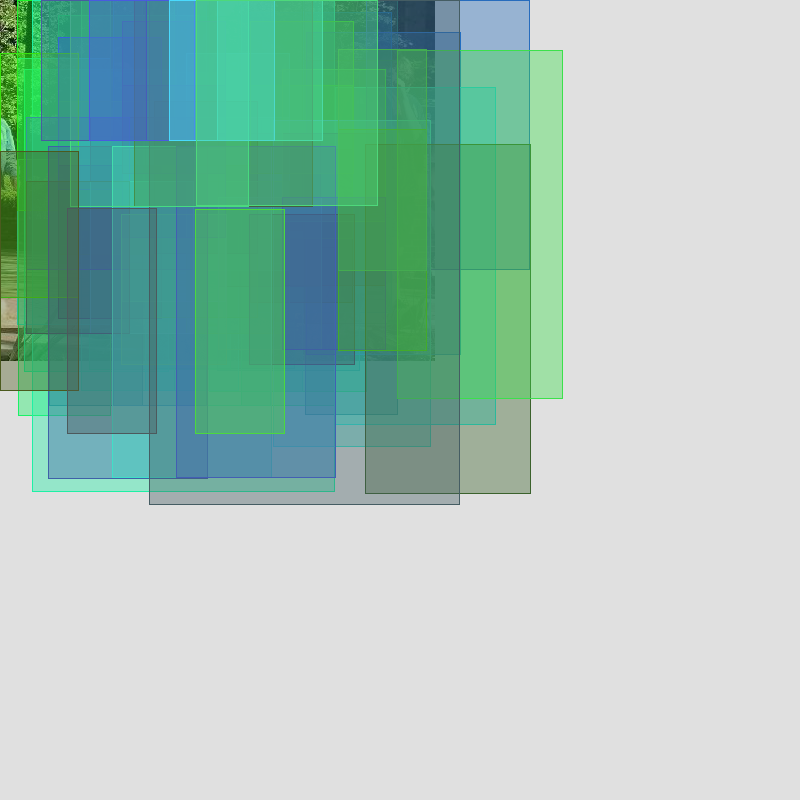

In [35]:
images, targets = next(i)
images = list(img.to(device) for img in images)
predictions = model(images)
img = images[0].detach() * 255 # C x H x W
img = img.type(torch.uint8) 
boxes = predictions[0]['boxes'] # xmin, ymin, xmax, ymax
img_with_bbox = draw_bounding_boxes(
    image=img, 
    boxes=boxes,
    fill=True).detach().cpu()
# plt.imshow(img_with_bbox.permute(1, 2, 0)) # H x W x C
ToPILImage()(img_with_bbox)